# Averaged XGBoost and LightGBM model
---

In [263]:
import math
import pandas as pd
import numpy as np
from scipy.stats import stats, norm, skew
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.special import boxcox1p
import lightgbm as lgb
import xgboost as xgb

%matplotlib inline
np.random.seed(2)

In [264]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [265]:
train = train.drop('Id', axis=1)
train.columns


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

# Filling NaNs

## TODO: spend some more time on these columns

### 1: strings

In [266]:
cols_with_none_as_nan = [
    "PoolQC", 
    "MiscFeature", 
    "Alley", 
    "Fence", 
    "FireplaceQu", 
    'GarageType', 
    'GarageFinish', 
    'GarageQual', 
    'GarageCond', 
    'BsmtQual', 
    'BsmtCond', 
    'BsmtExposure', 
    'Electrical', 
    'BsmtFinType1', 
    'BsmtFinType2', 
    "MasVnrType",
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'KitchenQual',
    'Functional',
    'SaleType']


o = train.dtypes[train.dtypes==object].index
print(o)

# fill missing text fields with a default string
object_columns = train[o]
test_object_columns = test[o]

# for these colunms the string 'None' will be inserted in place of nan
for col in cols_with_none_as_nan:
    object_columns.loc[:, col] = object_columns.loc[:, col].fillna('None')
    test_object_columns.loc[:, col] = test_object_columns.loc[:, col].fillna('None')

remaining_fix = object_columns.isnull().sum()
print('Fixes remaining on train set\n', remaining_fix[remaining_fix>0])

remaining_fix = test_object_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Fixes remaining on train set
 Series([], dtype: int64)
Fixes remaining on test set
 Series([], dtype: int64)


# From string to ordinal
Many categorical features contain **ordinal** values; the chart that follows shows that in most cases, the category influences the SalePrice label.

In [267]:
# Base scale, taken from 'OverallCond' feature
#   10   Very Excellent
#   9    Excellent
#   8    Very Good
#   7    Good
#   6    Above Average   
#   5    Average
#   4    Below Average   
#   3    Fair
#   2    Poor
#   1    Very Poor

#   Ex   Excellent (100+ inches) 
#   Gd   Good (90-99 inches)
#   TA   Typical (80-89 inches)
#   Fa   Fair (70-79 inches)
#   Po   Poor (&lt;70 inches
#   NA   No Basement

quals_mapping = {
    "Ex": 9,
    "Gd": 7,
    "Av": 5,
    "TA": 5,
    "Fa": 3,
    "Po": 2,
    "NA": 0,
    "None": 0
}
quals_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', ]

for c in object_columns.columns:
    if c in quals_columns:
        vals = np.unique(object_columns[c])
        print(c, vals)
        for v in quals_mapping:
            object_columns.loc[:,c] = object_columns[c].replace(to_replace=v, value=quals_mapping[v])
            test_object_columns.loc[:,c] = test_object_columns[c].replace(to_replace=v, value=quals_mapping[v])


ExterQual ['Ex' 'Fa' 'Gd' 'TA']


/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


ExterCond ['Ex' 'Fa' 'Gd' 'Po' 'TA']
BsmtQual ['Ex' 'Fa' 'Gd' 'None' 'TA']
BsmtCond ['Fa' 'Gd' 'None' 'Po' 'TA']
HeatingQC ['Ex' 'Fa' 'Gd' 'Po' 'TA']
KitchenQual ['Ex' 'Fa' 'Gd' 'TA']
FireplaceQu ['Ex' 'Fa' 'Gd' 'None' 'Po' 'TA']
GarageQual ['Ex' 'Fa' 'Gd' 'None' 'Po' 'TA']
GarageCond ['Ex' 'Fa' 'Gd' 'None' 'Po' 'TA']
PoolQC ['Ex' 'Fa' 'Gd' 'None']


In [268]:
for t in test_object_columns['KitchenQual']:
    print (t)

5
7
5
7
7
5
5
5
7
5
7
5
5
7
5
9
7
9
9
9
7
7
7
7
7
7
7
7
7
7
7
5
5
7
7
7
7
7
7
7
7
7
7
7
7
5
7
5
5
5
5
7
5
5
5
5
7
5
7
5
5
5
5
3
5
5
5
5
5
5
5
5
7
3
7
5
5
7
7
3
5
5
7
7
5
5
7
5
5
5
5
5
7
5
5
0
5
5
5
5
5
7
5
5
5
5
5
7
3
7
5
5
7
5
7
7
7
5
5
5
5
5
7
7
7
5
5
5
3
5
5
3
5
5
5
5
5
7
7
7
5
5
5
7
7
7
5
7
7
5
5
7
5
5
5
5
5
5
7
5
5
5
7
7
5
5
5
7
5
7
5
7
5
5
7
7
5
7
5
7
5
9
7
7
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
9
9
9
9
9
7
9
9
9
9
7
9
7
7
7
7
7
9
9
9
9
7
7
7
7
7
7
7
7
7
7
7
7
5
5
7
5
7
7
7
7
7
7
7
7
9
7
7
7
7
7
7
9
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
5
5
5
5
5
5
7
5
7
7
7
7
7
7
7
9
7
5
7
7
5
5
7
5
5
5
5
5
5
5
5
7
5
5
7
5
5
5
7
5
5
7
5
7
5
5
5
5
3
7
5
5
5
5
7
5
9
7
7
7
7
5
5
5
5
7
5
5
5
5
5
5
5
5
5
7
5
7
5
7
5
5
3
5
5
5
5
5
7
9
9
5
5
7
5
7
5
5
5
5
5
5
5
5
5
7
5
5
7
5
3
5
5
5
5
5
5
5
5
3
5
5
7
5
7
7
7
7
5
5
5
7
5
5
5
5
9
9
7
7
7
7
7
7
7
5
5
5
7
7
5
5
7
7
7
7
7
7
7
7
7
5
5
5
5
5
5
5
5
5
7
5
5
5
5
5
5
3
5
5
7
5
5
9
7
5
9
5
7
5
5
5
9
9
7
7
7
9
7
5
5
5
5
5
5
5
5
5
5
7
7
7
5
7
7
9
9
5
9
5
9
5
7
7
7
5
5
7
5
7
5
5


In [197]:

#plt.figure(figsize=(20,80))
#num_features = len(object_columns.columns)
#plot_columns_no = 3
#for i in range(1, num_features):
#    plt.subplot(math.ceil(num_features / plot_columns_no), plot_columns_no, i)
#    sns.boxplot(x=object_columns.loc[:,object_columns.columns[i-1]], y=train['SalePrice'])


In order to make the category influence the predicted price with the correct amount, I'm going to exchange each category with the mean saleprice value for all the entries with that category.

### 2: numerics

In [269]:
numeric_columns = train.select_dtypes(include=[int, float])

remaining_fix = numeric_columns.isnull().sum()
print('Fixes remaining on train set\n',remaining_fix[remaining_fix>0])

test_numeric_columns = test.select_dtypes(include=[int, float])

remaining_fix = test_numeric_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

Fixes remaining on train set
 LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64
Fixes remaining on test set
 LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt      78
GarageCars        1
GarageArea        1
dtype: int64


In [270]:
cols_with_zero_as_nan = ['MasVnrArea', 
                         'GarageYrBlt',
                         'BsmtFinSF1',
                         'BsmtFinSF2',
                         'BsmtUnfSF',
                         'TotalBsmtSF',
                         'BsmtFullBath',
                         'BsmtHalfBath',
                         'GarageCars',
                         'GarageArea',
                        ]
cols_with_mean_as_nan = ['LotFrontage']

# for these colunms the mean will be inserted in place of nan
for col in cols_with_mean_as_nan:
    numeric_columns.loc[:, col] = numeric_columns.loc[:, col].fillna(numeric_columns[col].mean())
    test_numeric_columns.loc[:, col] = test_numeric_columns.loc[:, col].fillna(test_numeric_columns[col].mean())

# for these colunms a zero will be inserted in place of nan
for col in cols_with_zero_as_nan:
    numeric_columns.loc[:, col] = numeric_columns.loc[:, col].fillna(0)
    test_numeric_columns.loc[:, col] = test_numeric_columns.loc[:, col].fillna(0)


remaining_fix = numeric_columns.isnull().sum()
print('Fixes remaining on train set\n',remaining_fix[remaining_fix>0])

remaining_fix = test_numeric_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Fixes remaining on train set
 Series([], dtype: int64)
Fixes remaining on test set
 Series([], dtype: int64)


# Features skewness
## TODO understand why skewness correction gives worse results

In [271]:
def fix_skewness(dataframe):
    skewed_feats = dataframe.apply(lambda x: abs(skew(x.dropna()))).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew': skewed_feats})
    skewness = skewness[abs(skewness) > 0.75].dropna()
    print("There are {} skewed numerical features to transform".format(skewness.shape[0]))
    print("\nSkew > .75 in numerical features: \n")
    print(skewness)
    # Fix skewness
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        if feat == 'SalePrice': continue
        dataframe[feat] = boxcox1p(dataframe[feat], lam)
    print('Fixed skewness')

fix_skewness(numeric_columns)
fix_skewness(test_numeric_columns)


There are 23 skewed numerical features to transform

Skew > .75 in numerical features: 

                    Skew
MiscVal        24.451640
PoolArea       14.813135
LotArea        12.195142
3SsnPorch      10.293752
LowQualFinSF    9.002080
KitchenAbvGr    4.483784
BsmtFinSF2      4.250888
ScreenPorch     4.117977
BsmtHalfBath    4.099186
GarageYrBlt     3.865524
EnclosedPorch   3.086696
MasVnrArea      2.674865
LotFrontage     2.382499
OpenPorchSF     2.361912
SalePrice       1.880941
BsmtFinSF1      1.683771
WoodDeckSF      1.539792
TotalBsmtSF     1.522688
MSSubClass      1.406210
1stFlrSF        1.375342
GrLivArea       1.365156
BsmtUnfSF       0.919323
2ndFlrSF        0.812194


/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Fixed skewness
There are 23 skewed numerical features to transform

Skew > .75 in numerical features: 

                    Skew
PoolArea       20.176117
MiscVal        20.054543
LowQualFinSF   16.150628
3SsnPorch      12.511336
EnclosedPorch   4.664371
KitchenAbvGr    4.074860
BsmtFinSF2      4.038796
GarageYrBlt     3.947954
ScreenPorch     3.784349
BsmtHalfBath    3.779085
LotArea         3.112013
OpenPorchSF     2.685015
MasVnrArea      2.546947
WoodDeckSF      2.128569
1stFlrSF        1.556592
MSSubClass      1.345305
BsmtFinSF1      1.165130
GrLivArea       1.129240
BsmtUnfSF       0.918977
2ndFlrSF        0.911944
TotRmsAbvGrd    0.841731
Fireplaces      0.819015
TotalBsmtSF     0.804238
Fixed skewness


# Enconding string columns with LabelEncoder

In [272]:

strings = np.array([])
for c in object_columns.columns:
    if c not in quals_columns:
        strings = np.append(strings, pd.unique(object_columns[c].values))

for c in test_object_columns.columns:
    if c not in quals_columns:
        strings = np.append(strings, pd.unique(test_object_columns[c].values))

print(len(strings), 'distinct labels generated')
print(strings)

labeler = LabelEncoder()
labeler.fit(strings)

for c in object_columns.columns:
    if c not in quals_columns:
        object_columns.loc[:,c] = labeler.transform(object_columns.loc[:,c])
        test_object_columns.loc[:,c] = labeler.transform(test_object_columns.loc[:,c])

object_columns[0:5]

423 distinct labels generated
['RL' 'RM' 'C (all)' 'FV' 'RH' 'Pave' 'Grvl' 'None' 'Grvl' 'Pave' 'Reg'
 'IR1' 'IR2' 'IR3' 'Lvl' 'Bnk' 'Low' 'HLS' 'AllPub' 'NoSeWa' 'Inside'
 'FR2' 'Corner' 'CulDSac' 'FR3' 'Gtl' 'Mod' 'Sev' 'CollgCr' 'Veenker'
 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes' 'OldTown' 'BrkSide'
 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR' 'MeadowV' 'Edwards'
 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill' 'Blmngtn' 'BrDale'
 'SWISU' 'Blueste' 'Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn'
 'PosA' 'RRNe' 'Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe'
 '1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs' '2Story' '1Story' '1.5Fin'
 '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin' 'Gable' 'Hip' 'Gambrel'
 'Mansard' 'Flat' 'Shed' 'CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran'
 'Tar&Grv' 'Roll' 'ClyTile' 'VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard'
 'BrkFace' 'WdShing' 'CemntBd' 'Plywood' 'AsbShng' 'Stucco' 'BrkComm'
 'AsphShn' 'Stone' 'ImStucc' 'CBlock' 'VinylSd' 'MetalSd' 

/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,130,124,112,137,87,12,85,76,41,113,...,17,128,5,5,169,0,112,112,161,114
1,130,124,112,137,87,12,53,76,159,57,...,17,128,5,5,169,0,112,112,161,114
2,130,124,112,81,87,12,85,76,41,113,...,17,128,5,5,169,0,112,112,161,114
3,130,124,112,81,87,12,47,76,48,113,...,50,158,5,5,169,0,112,112,161,10
4,130,124,112,81,87,12,53,76,110,113,...,17,128,5,5,169,0,112,112,161,114


# Assembling the datasets

In [273]:
# final train dataset
train_ds = object_columns.join(numeric_columns)
train_ds["SalePrice"] = np.log1p(train_ds["SalePrice"])

# test dataset
test_ds = test_object_columns.join(test_numeric_columns)

#correlation matrix
corrmat = train_ds.corr()['SalePrice']
#f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True);

best_columns = corrmat[abs(corrmat) > 0.0].index
train_ds = train_ds[best_columns]
test_ds = test_ds[best_columns.drop('SalePrice')]


In [274]:
X_train = (train_ds.values[:,:-1])
y_train = np.asarray([[t] for t in (train_ds.values[:,-1])])
X_test = test_ds.values

print('Training set features shape', X_train.shape)
print('Training set labels shape', y_train.shape)
print('Test set shape', test_ds.shape)


Training set features shape (1460, 79)
Training set labels shape (1460, 1)
Test set shape (1459, 79)


#### Removing outliers

In [275]:
print(test_ds.dtypes[test_ds.dtypes==object])

from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X_train)
X_train = pd.DataFrame(transformer.transform(X_train))
X_test = pd.DataFrame(transformer.transform(X_test))


Series([], dtype: object)


In [276]:
print('Training set features shape', X_train.shape)
print('Training set labels shape', y_train.shape)


Training set features shape (1460, 79)
Training set labels shape (1460, 1)


## Training functions

In [277]:
def train_model(depth, learning_rate, n_estimators, model_type='xgb'):
    if model_type == 'xgb':
        model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                 learning_rate=learning_rate, max_depth=depth, 
                                 min_child_weight=1.7817, n_estimators=n_estimators,
                                 reg_alpha=0.4640, reg_lambda=0.8571,
                                 subsample=0.5213, silent=1,
                                 random_state =7, nthread = -1)
    if model_type == 'lgb':
        model = lgb.LGBMRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                 learning_rate=learning_rate, max_depth=depth, 
                                 min_child_weight=1.7817, n_estimators=n_estimators,
                                 reg_alpha=0.4640, reg_lambda=0.8571,
                                 subsample=0.5213, silent=1,
                                 random_state =7, nthread = -1)
    score = rmsle_cv(model)
    print(model_type, " score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))
    return score

#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train.flatten(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# Training: XGBoost


In [278]:

result = []
for depth in range(3, 4):
    for learning_rate in range(2, 3, 1):
        for n_estimators in range(4000, 4800, 200):
            score = train_model(depth, learning_rate/100, n_estimators, model_type='xgb')
            result.append([depth, learning_rate/100, n_estimators, score.mean(), score.std()])


xgb  score: depth=3 lr=0.02 est=4000 -> mean:0.12206 std:0.0103
xgb  score: depth=3 lr=0.02 est=4200 -> mean:0.12200 std:0.0104
xgb  score: depth=3 lr=0.02 est=4400 -> mean:0.12194 std:0.0103
xgb  score: depth=3 lr=0.02 est=4600 -> mean:0.12188 std:0.0103


In [279]:
# check results
result = pd.DataFrame(result, columns=['depth', 'learning_rate', 'n_estimators', 'score_mean', 'score_std'])
result.describe()


,depth,learning_rate,n_estimators,score_mean,score_std
count,4.0,4.00,4.00000,4.000000,4.000000
mean,3.0,0.02,4300.00000,0.121970,0.010327
std,0.0,0.00,258.19889,0.000074,0.000027
min,3.0,0.02,4000.00000,0.121883,0.010288
25%,3.0,0.02,4150.00000,0.121928,0.010320
50%,3.0,0.02,4300.00000,0.121971,0.010334
75%,3.0,0.02,4450.00000,0.122013,0.010341
max,3.0,0.02,4600.00000,0.122056,0.010352


In [280]:
best = np.argmin(result['score_mean'].values)
print('Best params = \n', result.iloc[best])


Best params = 
 depth               3.000000
learning_rate       0.020000
n_estimators     4600.000000
score_mean          0.121883
score_std           0.010288
Name: 3, dtype: float64


* Best params = 
* depth               4.000000
* learning_rate       0.030000
* n_estimators     4400.000000
* score_mean          0.122068
* score_std           0.009581


In [281]:
# train with the best parameters
depth = int(result.iloc[best]['depth'])
learning_rate = result.iloc[best]['learning_rate']
n_estimators = int(result.iloc[best]['n_estimators'])

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                         learning_rate=learning_rate, max_depth=depth, 
                         min_child_weight=1.7817, n_estimators=n_estimators,
                         reg_alpha=0.4640, reg_lambda=0.8571,
                         subsample=0.5213, silent=1,
                         random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("Xgboost score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_train)
print('RMSLE XGB = ', rmsle(y_train, y_pred))


Xgboost score: depth=3 lr=0.02 est=4600 -> mean:0.12188 std:0.0103
RMSLE XGB =  0.08058859226105235


* Xgboost score: depth=4 lr=0.03 est=4400 -> mean:0.12207 std:0.0096
* RMSLE XGB =  0.07584312944985448


(1460, 1)
(1460, 1)
(1460,)


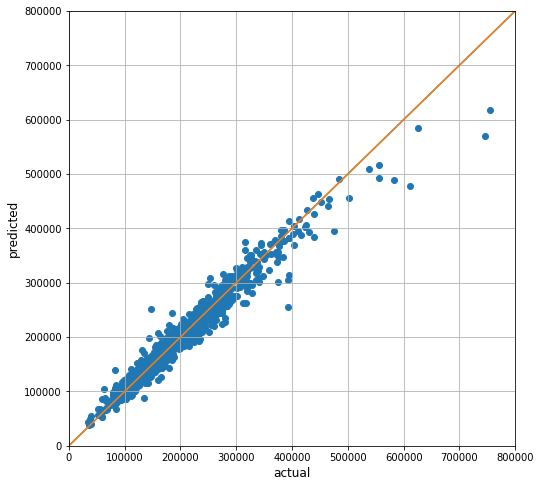

In [282]:
plt.figure(figsize=(8, 8))
y_pred = model_xgb.predict(X_train)
print(y_train.shape)
print(y_train.shape)
print(y_pred.shape)
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 800_000)
plt.ylim(0, 800_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.grid()
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()


# Training: lightgbm


In [283]:
result = []
for depth in range(3, 5):
    for learning_rate in range(3, 4, 1):
        for n_estimators in range(1200, 2000, 200):
            score = train_model(depth, learning_rate/100, n_estimators, model_type='lgb')
            result.append([depth, learning_rate/100, n_estimators, score.mean(), score.std()])


lgb  score: depth=3 lr=0.03 est=1200 -> mean:0.12702 std:0.0116
lgb  score: depth=3 lr=0.03 est=1400 -> mean:0.12699 std:0.0116
lgb  score: depth=3 lr=0.03 est=1600 -> mean:0.12704 std:0.0115
lgb  score: depth=3 lr=0.03 est=1800 -> mean:0.12709 std:0.0114
lgb  score: depth=4 lr=0.03 est=1200 -> mean:0.12738 std:0.0110
lgb  score: depth=4 lr=0.03 est=1400 -> mean:0.12740 std:0.0111
lgb  score: depth=4 lr=0.03 est=1600 -> mean:0.12740 std:0.0111
lgb  score: depth=4 lr=0.03 est=1800 -> mean:0.12740 std:0.0111


In [284]:
# check results
result = pd.DataFrame(result, columns=['depth', 'learning_rate', 'n_estimators', 'score_mean', 'score_std'])
result.describe()


,depth,learning_rate,n_estimators,score_mean,score_std
count,8.000000,8.00,8.000000,8.000000,8.000000
mean,3.500000,0.03,1500.000000,0.127213,0.011287
std,0.534522,0.00,239.045722,0.000194,0.000250
min,3.000000,0.03,1200.000000,0.126988,0.011044
25%,3.000000,0.03,1350.000000,0.127033,0.011060
50%,3.500000,0.03,1500.000000,0.127237,0.011247
75%,4.000000,0.03,1650.000000,0.127395,0.011523
max,4.000000,0.03,1800.000000,0.127396,0.011571


In [285]:
best = np.argmin(result['score_mean'].values)
print('Best params = \n', result.iloc[best])


Best params = 
 depth               3.000000
learning_rate       0.030000
n_estimators     1400.000000
score_mean          0.126988
score_std           0.011571
Name: 1, dtype: float64


* Best params = 
* depth               4.000000
* learning_rate       0.020000
* n_estimators     1600.000000
* score_mean          0.126387
* score_std           0.010963


In [286]:
# train with the best parameters
depth = int(result.iloc[best]['depth'])
learning_rate = result.iloc[best]['learning_rate']
n_estimators = int(result.iloc[best]['n_estimators'])

model_lgb = lgb.LGBMRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                         learning_rate=learning_rate, max_depth=depth, 
                         min_child_weight=1.7817, n_estimators=n_estimators,
                         reg_alpha=0.4640, reg_lambda=0.8571,
                         subsample=0.5213, silent=1,
                         random_state =7, nthread = -1)


score = rmsle_cv(model_lgb)
print("lgb score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))

model_lgb.fit(X_train, y_train.flatten())
y_pred = model_lgb.predict(X_train)

print('RMSLE LGB = ', rmsle(y_train, y_pred))


lgb score: depth=3 lr=0.03 est=1400 -> mean:0.12699 std:0.0116
RMSLE LGB =  0.06883421641765004


* lgb score: depth=4 lr=0.02 est=1600 -> mean:0.12639 std:0.0110
* RMSLE LGB =  0.05778702152750832


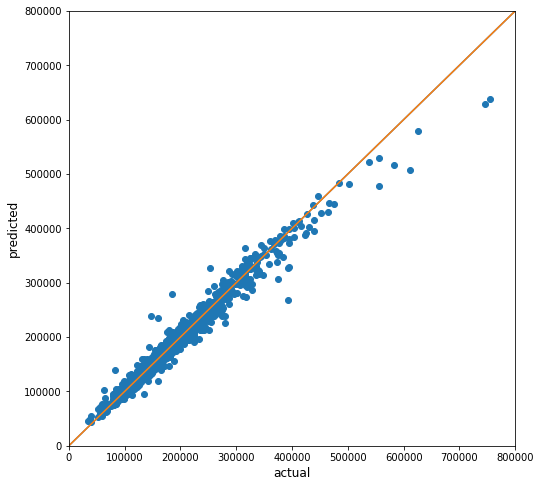

In [287]:

plt.figure(figsize=(8, 8))
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 800_000)
plt.ylim(0, 800_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()


# Averaged model

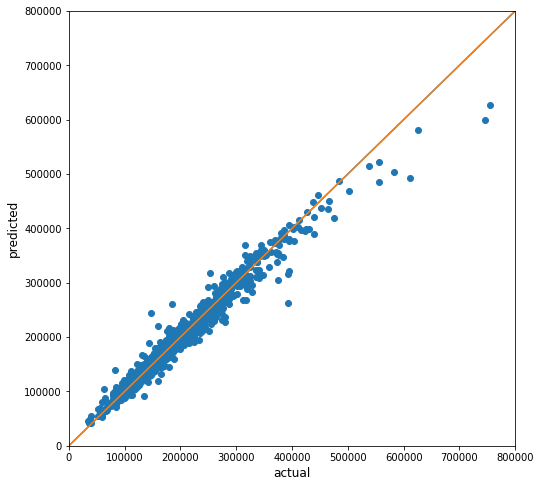

RMSLE LGB =  0.07343068252959209


In [288]:
avg_predict = (model_lgb.predict(X_train) + model_xgb.predict(X_train)) / 2
y_pred = avg_predict

plt.figure(figsize=(8, 8))
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 800_000)
plt.ylim(0, 800_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()

print('RMSLE LGB = ', rmsle(y_train, y_pred))



# Target: RMSLE LGB =  0.06539346038526068


In [289]:
# Submission
print(np.expm1(model_xgb.predict(X_test)[0:5]))
print(np.expm1(model_lgb.predict(X_test)[0:5]))
avg_predict = (model_xgb.predict(X_test) + model_lgb.predict(X_test)) / 2
subm_predict = np.expm1(avg_predict)

dsubm_predict = pd.DataFrame(subm_predict)
dsubm_predict['Id'] = test.values[:,0]
dsubm_predict.columns = ['SalePrice', 'Id']

dsubm_predict.to_csv('submission.csv', index=False)
dsubm_predict[0:10]


[125352.32 160749.53 175329.6  186423.97 193482.2 ]
[119771.32363239 159248.73665308 184006.45537788 186371.90988333
 189541.09178178]


,SalePrice,Id
0,122530.051570,1461
1,159997.371283,1462
2,179615.635572,1463
3,186397.939772,1464
4,191501.508677,1465
5,169194.064696,1466
6,167713.040221,1467
7,165396.466284,1468
8,172175.079081,1469
9,125426.225923,1470


# Best score on kaggle: 0.12276